# Welcome to PsyNeuLink

PsyNeuLink is an integrated language and toolkit for creating cognitive models. It decreases the overhead required for cognitive modeling by providing standard building blocks (DDMS, Neural Nets, etc.) and the means to connect them together in a single environment. PsyNeuLink is designed to make the user think about computation in a "mind/brain-like" way while imposing minimal constraints on the type of models that can be implemented.

## How to get PsyNeuLink

PsyNeuLink is compatible with python versions >= 3.7 and is available through PyPI:

```shell
pip install psyneulink
```
Or you can clone the GitHub repo [here](https://github.com/PrincetonUniversity/PsyNeuLink). Download the package with the green "Clone or download" button on the right side of the page and "Download ZIP." Open the version of this Tutorial in the cloned folder before continuing on.

## Installation

To install the package, navigate to the cloned directory in a terminal, switch to your preferred python3 environment, then run the command `pip install .` (make sure to include the period and to use the appropriate pip/pip3 command for python 3.7). All prerequisite packages will be automatically added to your environment.

For the curious, these are:
* numpy
* matplotlib
* toposort
* mpi4py
* typecheck-decorator


## Tutorial Overview

This tutorial is meant to get you accustomed to the structure of PsyNeuLink and be able to construct basic models. Starting with a simple 1-to-1 transformation, we will build up to making the Stroop model from [Cohen et al. (1990)](https://www.researchgate.net/publication/20956134_Cohen_JD_McClelland_JL_Dunbar_K_On_the_control_of_automatic_processes_a_parallel_distributed_processing_account_of_the_Stroop_effect_Psychol_Rev_97_332-361). Let's get started!

### Imports and file structure

The following code block will import the necessary components for basic neural network models in PsyNeuLink. In particular, we need tools for handling *[Compositions](https://princetonuniversity.github.io/PsyNeuLink/Composition.html)*, the set of specific *[Mechanisms](https://princetonuniversity.github.io/PsyNeuLink/Mechanism.html)* that will make up our networks, and the *[Projections](https://princetonuniversity.github.io/PsyNeuLink/Projection.html)* to connect them. We also import basic prerequisites and set up the jupyter environment for visualization.

In [20]:
!pip install psyneulink #run this command if opening in Google CoLaboratory 
import psyneulink as pnl


[notice] A new release of pip is available: 23.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Creating a Mechanism

*[Mechanisms](https://princetonuniversity.github.io/PsyNeuLink/Mechanism.html)* are the basic units of computation in PsyNeuLink. At their core is a parameterized *function* but they also contain the machinery to interact with input, output, control, and learning signals. Our first Mechanism will perform a linear transformation on a scalar input. For now, we will initialize it by just specifying the *function* of the Mechanism.

In [22]:
linear_transfer_mechanism = pnl.TransferMechanism(
    function=pnl.Linear(slope=1, intercept=0))

In this case, we didn't actually need to specify the slope and intercept as the function will default to reasonable values (if we didn't specify, it would have defaulted to a slope of 1 and intercept of 0).  The function above has two parameters: slope and intercept.  If we wrote the equation as $y = ax + b$, $a$ is the slope, $b$ is the intercept, $x$ is the input, and $y$ is the output.  As a function, we write this $f(x) = ax + b$.  Note that you can change these parameter values of $a=1$ and $b=0$ to other numbers -- because parameters are variables within a function.  

Some transfer functions other than Linear that you could use are `pnl.Exponential`, `pnl.Logistic`, or `pnl.SoftMax`. The exponential function raises a constant base to a variable exponent. The output of a logistic function is bounded between 0 and 1, and we'll learn a bit more about it later in this tutorial.  SoftMax is a more complex function that is often used in neural networks, and you don't need to understand how it works yet.     

Next, let's try inputting the number 2 into our linear transfer Mechanism...

In [23]:
linear_transfer_mechanism.execute([2])

array([[2.]])

Try reparamaterizing the Mechanism (change the slope and/or intercept) and executing again before moving on...  

If you change the slope to 3, run the code by pressing play, then change the input value to 4, what output do you get?  Why?  Can you predict what will happen if you change the slope to 4 and the intercept to 5 and run both cells again with an input of 3? 

Another way of expressing this function is $(slope x input) + intercept$. 

### Logistic Function

The standard logistic function is defined as $f(x) = \frac{1}{1 + e^{-x}}$

Psyneulink allows us to adjust this function with the parameters scale, gain, bias, and offset:

$scale * \frac{1}{1 + e^{-gain * (variable + bias)} + offset}$

The following cell plots a logistic function with the default parameters: $scale = 1$, $gain = 1$, $bias = 0$, and $offset = 0$.   

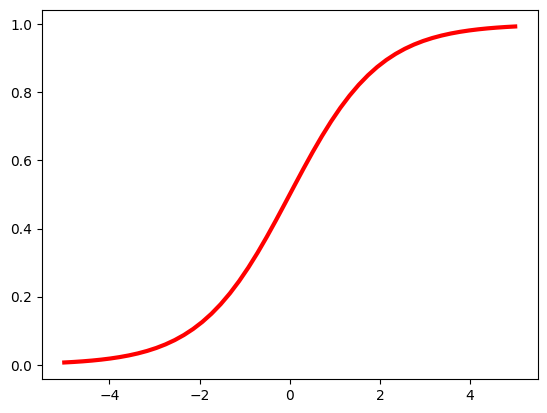

In [24]:
logistic_transfer_demo = pnl.TransferMechanism(function=pnl.Logistic(scale=1, gain=1, bias=0, offset=0))
logistic_transfer_demo.plot()

In the cell below you can plug a single number into this function and get an output value.  Your input corresponds to a point on the x axis, and the output is the corresponding y value (height of the point on the curve above the x you specified).   

In [25]:
logistic_transfer_demo.execute([-2])

array([[0.11920292]])

The logistic function is useful because it is bounded between 0 and 1.  Gain determines how steep the central portion of the S-curve is, with higher values being steeper.  Bias shifts the curve left or right. You can turn the logistic function effectively into a step function that works as a threshold by increasing gain. The step in the step function (where it crosses through 0.5 on the y-axis) is located on the x-axis at $\frac{offset}{gain} + bias$.

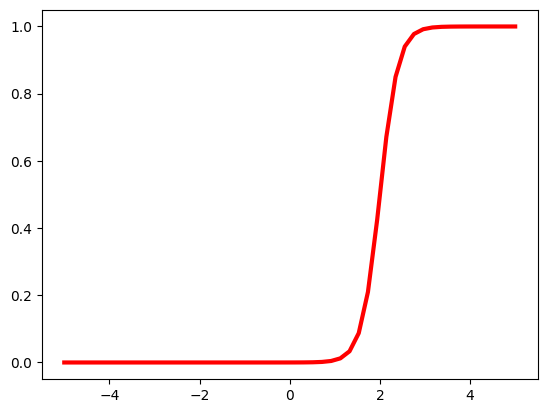

In [26]:
logistic_transfer_offgain = pnl.TransferMechanism(function=pnl.Logistic(gain=5,offset=10, bias=0))
logistic_transfer_offgain.plot()

Negative values of gain mirror reverse the S-curve accross the vertical axis, centered at the x-value of $\frac{offset}{gain} + bias$.  Below notice that $\frac{offset}{gain}$ is -2 (10/-5), and at an x-value of -2 the y-value is 0.5 $(f(-2) = 0.5)$.  

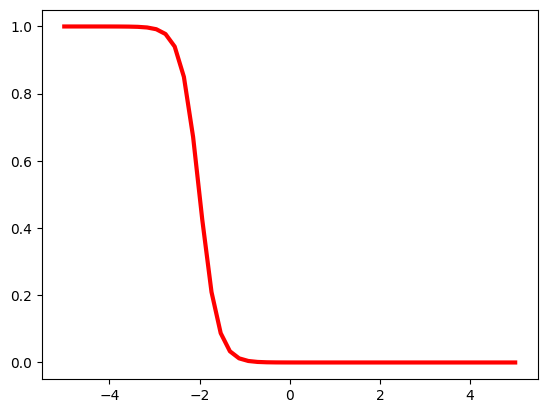

In [27]:
logistic_transfer_invert = pnl.TransferMechanism(function=pnl.Logistic(gain=-5, bias=0, offset=10))
logistic_transfer_invert.plot()

### From Nodes to Graphs: Compositions

Generally with PsyNeuLink, you won't be executing Mechanisms as stand-alone entities. Rather, Mechanisms will be nodes in a graph, with *Projections* as edges of the graph, connecting nodes.  We call the graph a *Composition*.    

The simplest kind of Composition is one-dimensional: a linear progression from one node to the next. Information flowing through this graph will be entered as input, processed in the first Mechanism, transferred via Projection to the next Mechanism, and so on. You can think of this with an analogy to digestion. Chew the food first, then swallow it, and it is "projected" to the stomach. Then, the stomach soaks food in digestive acid to further break it down. Then, the output is projected to the small intestine, where nutrients are absorbed.  Note that the order matters -- the small intestine wouldn't be effective if the food hadn't been chewed and then broken down in the stomach. 

A Mechanism takes some input, performs a function, and delivers an output. The same is typically true for Compositions -- they take some input, perform multiple functions using multiple Mechanisms, and deliver some output. A powerful feature of this input-output architecture is that an entire composition today can become a Mechanism tomorrow as part of a more complex Composition, and that Composition can become a Mechanism in yet a more complex Composition all the way up. [Note: This is true in principle, but PsyNeuLink is actively under development, and such scaled-up functionality is not fully implemented.]

The main parameter when initializing a Composition is its pathway, which is an ordered list of Mechanisms and Projections. Of course, with only one Mechanism in our current Composition, the list has just one element.

To better see how the Composition runs, we can also turn on output reporting. Reporting can happen at every level in PsyNeuLink, and here we set the preference for the Mechanism.

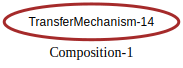

In [28]:
comp_simplest = pnl.Composition()
comp_simplest.add_linear_processing_pathway(pathway = [linear_transfer_mechanism])
                                          
linear_transfer_mechanism.reportOutputPref = True
comp_simplest.show_graph(output_fmt = 'jupyter')

In [29]:
comp_simplest.run([4])

array([[4.]])

Let's turn off the reporting and look at our process' output over a wider range of values.

---------------------------------------------------

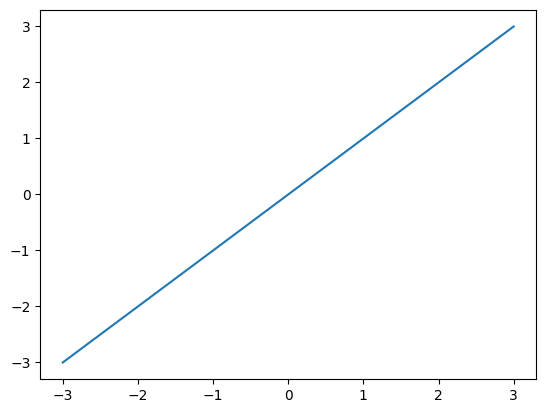

In [30]:
linear_transfer_mechanism.reportOutputPref = False

xVals = np.linspace(-3, 3, num=51) # create 51 points between -3 and +3
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = comp_simplest.run([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

Now let's put it all together and make a new transfer process, this time with a logistic activation function. We will also extend our Mechanism by giving it two units (operating on a 1x2 matrix) rather than the default one (operating on a scalar).

---------------------------------------------------

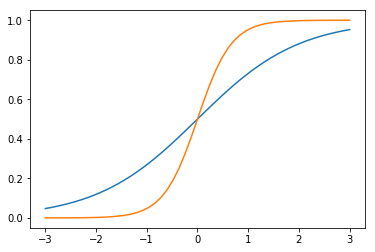

In [0]:
# Create Composition
comp_1x2 = pnl.Composition()

# Create the Mechanism
logistic_transfer_mechanism = pnl.TransferMechanism(default_variable=[0, 0],
                                                function=pnl.Logistic(gain=1,
                                                                  bias=0))
# Place Mechanism in Composition
comp_1x2.add_linear_processing_pathway(pathway = [logistic_transfer_mechanism])


# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
y1Vals = np.zeros((51,))
y2Vals = np.zeros((51,))
for i in range(xVals.shape[0]):
    # clarify why multiplying times 2
    output = comp_1x2.run([xVals[i], xVals[i] * 3])
    y1Vals[i] = output[0][0]
    y2Vals[i] = output[0][1]
    # Progress bar
    print("-", end="")
plt.plot(xVals, y1Vals)
plt.plot(xVals, y2Vals)
plt.show()

The `default_variable` parameter serves a dual function. It specifies the dimensionality of the Mechanism as well as providing the inputs that will be given in the absence of explicit input at runtime.  You can also specify the dimensionality using "size", e.g. size=2 will also create default_variable=[0,0].

In [0]:
logistic_transfer_step = pnl.TransferMechanism(default_variable=[0, 0],
                                                function=pnl.Logistic(gain=100,
                                                                  offset=100))

In [0]:
logistic_transfer_step.execute([.9,1.1])

array([[4.53978687e-05, 9.99954602e-01]])

### Adding Projections

To connect Mechanisms together in a Composition, we need a way to link Mechanisms together. This is done through [Projections](https://princetonuniversity.github.io/PsyNeuLink/Projection.html). A projection takes a Mechanism output, multiplies it by the Projection's mapping matrix, and delivers the transformed value to the next Mechanism in the Composition. 

---------------------------------------------------

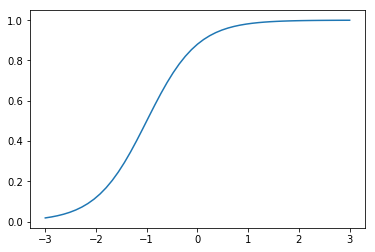

In [0]:
# Create Composition
comp_linlog = pnl.Composition()

# Create Mechanisms
linear_input_unit = pnl.TransferMechanism(function=pnl.Linear(slope=2, intercept=2))
logistic_output_unit = pnl.TransferMechanism(function=pnl.Logistic())

# Place Mechanism in Composition
comp_linlog.add_linear_processing_pathway(pathway = [linear_input_unit, pnl.IDENTITY_MATRIX, logistic_output_unit])


# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = comp_linlog.run([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

`IDENTITY_MATRIX` is a keyword that provides a Projection from the unit preceding it to the unit following, creating a one-to-one output-to-input Projection between the two. 

Now, let's make our Projection definition a bit more explicit.

---------------------------------------------------

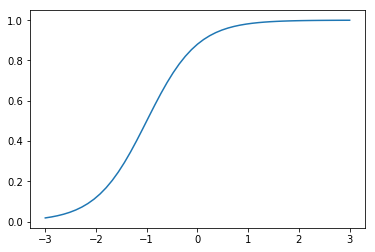

In [0]:
# Create Composition
comp_explicit = pnl.Composition()

# Create Mechanisms
linear_input_unit = pnl.TransferMechanism(function=pnl.Linear(slope=2, intercept=2), name="linear")
logistic_output_unit = pnl.TransferMechanism(function=pnl.Logistic(), name="logistic")

# Create Projection
mapping_matrix = np.asarray([[1]])
unit_mapping_projection = pnl.MappingProjection(sender=linear_input_unit,
                                            receiver=logistic_output_unit,
                                            matrix=mapping_matrix)

# Place Mechanisms and Projections in Composition
comp_explicit.add_linear_processing_pathway(pathway = [linear_input_unit, unit_mapping_projection, logistic_output_unit])


# Iterate and plot
xVals = np.linspace(-3, 3, num=51)
yVals = np.zeros((51,))
for i in range(xVals.shape[0]):
    yVals[i] = comp_explicit.run([xVals[i]])[0]
    # Progress bar
    print("-", end="")
plt.plot(xVals, yVals)
plt.show()

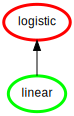

In [0]:
comp_explicit.show_graph(output_fmt = 'jupyter')

This time, we specified our mapping matrix (which is a 2-D numpy array) and then explicitly initialized a *[MappingProjection](https://princetonuniversity.github.io/PsyNeuLink/MappingProjection.html)* with that matrix as well as its input and output Mechanisms. Note: Because we specified the input and output Mechanisms in the Projection itself, we didn't need to include them in the Composition pathway as the Composition would have inferred its position from those parameters. Ultimately, however, this does the exact same thing as our keyword method above, which is far less verbose for this common use case.

### Compositions

The highest level at which models are considered in PsyNeuLink is that of the *[Composition](https://princetonuniversity.github.io/PsyNeuLink/Composition.html)*. A Composition is built out of one or more Mechanisms connected by Projections. This allows Composition graphs to be more complex than the strictly linear ones covered so far. Our first Composition will consist of two input nodes that converge on a single output Mechanism. We will be modeling competition between color naming and word reading in the Stroop task.  [Recall that the Stroop task involves naming the ink color of words: when the word itself mismatches with the ink color it is written in (e.g., the word RED written in blue ink), that produces conflict and slower response times to name the ink color.]

### Mini-Stroop Model

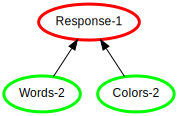

In [0]:
mini_stroop = pnl.Composition()

colors = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear,
                           name="Colors")
words = pnl.TransferMechanism(default_variable=[0, 0],
                          function=pnl.Linear(slope=1.5), name="Words")
response = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Logistic,
                             name="Response")


# Place Mechanisms and Projections in Composition
mini_stroop.add_linear_processing_pathway(pathway = [colors, response])
mini_stroop.add_linear_processing_pathway(pathway = [words, response])


mini_stroop.show_graph(output_fmt = 'jupyter')

An input of [1, 0] to ink is red ink, and [0, 1] is blue ink.  
An input of [1, 0] to word is "red" and [0, 1] is "blue".  
If the input values to ink and word are the same, that is a congruent trial.  If the input values to the ink and word are different that is an incongruent trial.  

In the output of the Composition, the first output value is the strength to respond red, and the second value is the strength to respond blue.  

In the following two cells, we will first specify a congruent trial (blue ink, word "blue") to see the output, and then specify an incongruent trial (red ink, word "blue").

In [0]:
input_allblue = {colors: [0, 1],
              words: [0, 1]}
mini_stroop.run(input_allblue)

[array([0.5       , 0.92414182])]

In [0]:
input_redblue = {colors: [1, 0], 
         words: [0, 1]}
mini_stroop.run(input_redblue)

[array([0.73105858, 0.81757448])]

### Pre-trained Complete Stroop Model

Let's practice using Compositions by recreating the more complex Stroop model from Cohen et al. (1990). Later, we will train the network ourselves, but for now, we will explicitly model the learned weights.

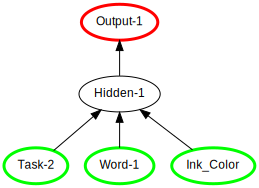

In [0]:
stroop_model = pnl.Composition()

ink_color = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear(),name="Ink_Color")
word = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear(),name="Word")
task_demand = pnl.TransferMechanism(default_variable=[0, 0], function=pnl.Linear(),name="Task")

hidden_layer = pnl.TransferMechanism(default_variable=[0, 0, 0, 0],
                                 function=pnl.Logistic(bias=-4), name="Hidden")

output_layer = pnl.TransferMechanism(default_variable=[[0, 0]], function=pnl.Linear(), name="Output")


color_mapping_matrix = np.asarray([[2.2, -2.2, 0, 0], [-2.2, 2.2, 0, 0]])
color_projection = pnl.MappingProjection(sender=ink_color, receiver=hidden_layer,
                                     matrix=color_mapping_matrix)
word_mapping_matrix = np.asarray([[0, 0, 2.6, -2.6], [0, 0, -2.6, 2.6]])
word_projection = pnl.MappingProjection(sender=word, receiver=hidden_layer,
                                    matrix=word_mapping_matrix)
task_mapping_matrix = np.asarray([[4, 4, 0, 0], [0, 0, 4, 4]])
task_projection = pnl.MappingProjection(sender=task_demand, receiver=hidden_layer,
                                    matrix=task_mapping_matrix)
output_mapping_matrix = np.asarray(
    [[1.3, -1.3], [-1.3, 1.3], [2.5, -2.5], [-2.5, 2.5]])
output_projection = pnl.MappingProjection(sender=hidden_layer, receiver=output_layer,
                  matrix=output_mapping_matrix)


stroop_model.add_linear_processing_pathway(pathway = [ink_color, color_projection, hidden_layer, output_projection, output_layer])
stroop_model.add_linear_processing_pathway(pathway = [word, word_projection, hidden_layer, output_projection, output_layer])
stroop_model.add_linear_processing_pathway(pathway = [task_demand, task_projection, hidden_layer, output_projection, output_layer])


ink_color.reportOutputPref = True
word.reportOutputPref = True
task_demand.reportOutputPref = True
hidden_layer.reportOutputPref = True

stroop_model.show_graph(output_fmt = 'jupyter')

In the next cell, we will run the model with inputs.  The "ink_color" and "word" are the same as the previous model, and the addition of task demand allows us to specify whether the task is to name the color of ink [0, 1], or to read the word [1, 0].  The output can be thought of as activation strengths of two possible responses [red, blue].  

In [0]:
input_dict = {ink_color: [1, 0],
              word: [0, 1],
              task_demand: [1, 0]}
stroop_model.run(input_dict)


'Ink_Color' mechanism executed:
- input:  [array([1., 0.])]
- params:
	convergence_criterion: 0.01
	convergence_function: Distance Function-1
		intercept: 0.0
		slope: 1.0
	function: Linear Function-1038
		intercept: 0.0
		slope: 1.0
	initial_value: None
	integration_rate: 0.5
	integrator_mode: False
	max_passes: 1000
	noise: 0.
- output: 0.0 0.0

'Word-1' mechanism executed:
- input:  [array([0., 1.])]
- params:
	convergence_criterion: 0.01
	convergence_function: Distance Function-1
		intercept: 0.0
		slope: 1.0
	function: Linear Function-1048
		intercept: 0.0
		slope: 1.0
	initial_value: None
	integration_rate: 0.5
	integrator_mode: False
	max_passes: 1000
	noise: 0.
- output: 0.0 0.0

'Task-2' mechanism executed:
- input:  [array([1., 0.])]
- params:
	convergence_criterion: 0.01
	convergence_function: Distance Function-1
		intercept: 0.0
		slope: 1.0
	function: Linear Function-1058
		intercept: 0.0
		slope: 1.0
	initial_value: None
	integration_rate: 0.5
	integrator_mode: False
	ma

[array([ 0.54950475, -0.54950475])]

To get a better sense of how the model works, try reverse engineering by changing each of the inputs (remember the options are only [1,0] or [0,1]) one at a time and running the model. Given 3 input states (Task, Word, Ink) with 2 options each, there will be 8 possibilities (2^3).  



# Constructing Compositions

As shown in the Stroop models above, Mechanisms are the building blocks in PsyNeuLink, and Projections are how these building blocks get connected.  The configuration of Mechanisms connected by Projections determines how information will flow and be processed within each model.  Next, we'll explore how to build models with different configurations of Mechanisms and Projections, along with generating diagrams that visualize these configurations.   

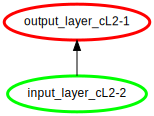

In [0]:
# Create Composition
comp_line2 = pnl.Composition()

input_layer_cL2 = pnl.TransferMechanism(
    name='input_layer_cL2',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_layer_cL2 = pnl.TransferMechanism(
    name='output_layer_cL2',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

# Place Mechanisms in Composition
comp_line2.add_linear_processing_pathway(pathway = [input_layer_cL2, output_layer_cL2])


input_layer_cL2.reportOutputPref = True
output_layer_cL2.reportOutputPref = True

comp_line2.show_graph(output_fmt = 'jupyter')

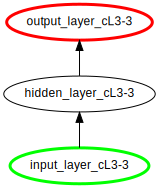

In [0]:
# Create Composition
comp_line3 = pnl.Composition()

# Create Mechanisms
input_layer_cL3 = pnl.TransferMechanism(
    name='input_layer_cL3',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)


hidden_layer_cL3 = pnl.TransferMechanism(
    name='hidden_layer_cL3',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_layer_cL3 = pnl.TransferMechanism(
    name='output_layer_cL3',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)



# Place Mechanisms in Composition
comp_line3.add_linear_processing_pathway(pathway = [input_layer_cL3, hidden_layer_cL3, output_layer_cL3])

input_layer_cL3.reportOutputPref = True
hidden_layer_cL3.reportOutputPref = True
output_layer_cL3.reportOutputPref = True

comp_line3.show_graph(output_fmt = 'jupyter')

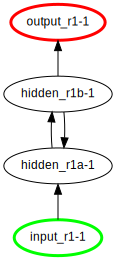

In [0]:
# Create Composition
comp_recur1 = pnl.Composition()

input_r1 = pnl.TransferMechanism(
    name='input_r1',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)


hidden_r1a = pnl.TransferMechanism(
    name='hidden_r1a',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_r1b = pnl.TransferMechanism(
    name='hidden_r1b',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_r1 = pnl.TransferMechanism(
    name='output_r1',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)


# Place Mechanisms in Composition
comp_recur1.add_linear_processing_pathway(pathway = [input_r1, hidden_r1a, hidden_r1b, output_r1])
comp_recur1.add_linear_processing_pathway(pathway = [hidden_r1b, hidden_r1a])


input_r1.reportOutputPref = True
hidden_r1a.reportOutputPref = True
hidden_r1b.reportOutputPref = True
output_r1.reportOutputPref = True

comp_recur1.show_graph(output_fmt = 'jupyter')

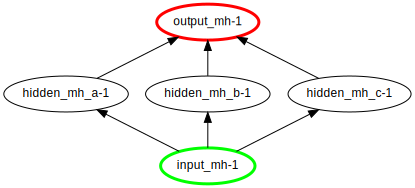

In [0]:
# Create Composition
comp_multihidden = pnl.Composition()

input_mh = pnl.TransferMechanism(
    name='input_mh',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_mh_a = pnl.TransferMechanism(
    name='hidden_mh_a',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_mh_b = pnl.TransferMechanism(
    name='hidden_mh_b',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

hidden_mh_c = pnl.TransferMechanism(
    name='hidden_mh_c',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)

output_mh = pnl.TransferMechanism(
    name='output_mh',
    function=pnl.Linear,
    default_variable=np.ones((4,)),
)


# Place Mechanisms in Composition
comp_multihidden.add_linear_processing_pathway(pathway = [input_mh, hidden_mh_a, output_mh])
comp_multihidden.add_linear_processing_pathway(pathway = [input_mh, hidden_mh_b, output_mh])
comp_multihidden.add_linear_processing_pathway(pathway = [input_mh, hidden_mh_c, output_mh])



input_mh.reportOutputPref = True
hidden_mh_a.reportOutputPref = True
hidden_mh_b.reportOutputPref = True
hidden_mh_c.reportOutputPref = True
output_mh.reportOutputPref = True

comp_multihidden.show_graph(output_fmt = 'jupyter')

This is currently the end of the tutorial, but more content is being added weekly. For further examples, look to the Scripts folder inside your PsyNeuLink directory for a variety of functioning models.